In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml

In [403]:
match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/match_data.csv', delimiter=";", index_col=False)
player_match_data = pd.read_csv('/Users/jon/Documents/fpl_points_prediction/ERD/tables/player_match_data_withid.csv', delimiter=";", index_col=False)

#Merge main two tables
merged_data = player_match_data.merge(match_data, left_on='match_id', right_on='match_id', how='outer')
merged_data = merged_data.drop('value', axis=1)
merged_data = merged_data.drop('own_goals', axis=1) #Variation isn't large enough 104
merged_data = merged_data.drop('red_cards', axis=1) #Variation isn't large enough 111
merged_data = merged_data.drop('npxG', axis=1) #not using npg
merged_data = merged_data.drop('player_match_id', axis=1)

#Turning 'home' and 'away' into players team and opponent team for analysis
merged_data['p_team_spi'] = merged_data.apply(lambda row: row.h_team_spi if row.was_home == 1 else row.a_team_spi, axis=1)
merged_data['oppn_spi'] = merged_data.apply(lambda row: row.a_team_spi if row.was_home == 1 else row.h_team_spi, axis=1)
merged_data['prob_p_team_win'] = merged_data.apply(lambda row: row.prob_h_win if row.was_home == 1 else row.prob_a_win, axis=1)
merged_data['prob_oppn_win'] = merged_data.apply(lambda row: row.prob_a_win if row.was_home == 1 else row.prob_h_win, axis=1)
merged_data['p_team_proj_score'] = merged_data.apply(lambda row: row.h_proj_score if row.was_home == 1 else row.a_proj_score, axis=1)
merged_data['oppn_team_proj_score'] = merged_data.apply(lambda row: row.a_proj_score if row.was_home == 1 else row.h_proj_score, axis=1)
merged_data['importance_p_team'] = merged_data.apply(lambda row: row.importance_h if row.was_home == 1 else row.importance_a, axis=1)
merged_data['importance_oppn_team'] = merged_data.apply(lambda row: row.importance_a if row.was_home == 1 else row.importance_h, axis=1)
#merged_data['score_p_team'] = merged_data.apply(lambda row: row.h_score if row.was_home == 1 else row.a_score, axis=1)
#merged_data['score_oppn_team'] = merged_data.apply(lambda row: row.a_score if row.was_home == 1 else row.h_score, axis=1)
#merged_data['xg_p_team'] = merged_data.apply(lambda row: row.h_xg if row.was_home == 1 else row.a_xg, axis=1)
#merged_data['xg_oppn_team'] = merged_data.apply(lambda row: row.a_xg if row.was_home == 1 else row.h_xg, axis=1)
#Additional features created
merged_data['opp_adv_spi'] = merged_data['oppn_spi'] - merged_data['p_team_spi']

#Creating lagged varibaled and lagged moving average varibales
#Sort values by player_id and date
lagged_data = merged_data.sort_values(['player_id', 'date'])

#Total points
def average_form(var):
    lagged_data[var+'-1'] = lagged_data.groupby('player_id')[var].shift(1) #Lagged once
    lagged_data[var+'-2'] = lagged_data.groupby('player_id')[var].shift(2) #Lagged twice
    lagged_data[var+'-3'] = lagged_data.groupby('player_id')[var].shift(3) #etc.
    lagged_data[var+'-4'] = lagged_data.groupby('player_id')[var].shift(4)
    lagged_data[var+'_lag_avg2'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'])/2 #lagged 2 week moving average 
    lagged_data[var+'_lag_avg3'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'])/3 #lagged 3 week moving average
    lagged_data[var+'_lag_avg4'] = (lagged_data[var+'-1'] + lagged_data[var+'-2'] + lagged_data[var+'-3'] + lagged_data[var+'-4'])/4 #etc.

for i, var in enumerate(['total_points','xP','bonus','bps','minutes','goals','shots','xG','xA','assists','key_passes','npg','xGChain','xGBuildup','yellow_cards','clean_sheets','goals_conceded','penalties_missed','penalties_saved','saves','influence','creativity','threat','ict_index']):
    average_form(var)

#remove date now used for lagging
lagged_data = lagged_data.drop('date', axis=1)
#Drop rows with NaN values caused by lagging.
lagged_data = lagged_data.dropna() 

#Drop game specific data that is not needed for the model
lagged_data = lagged_data.drop(['xP', 'minutes', 'bonus', 'bps', 'goals', 'shots', 'xG', 'xA',
       'assists', 'key_passes', 'npg', 'xGChain', 'xGBuildup', 'yellow_cards', 'clean_sheets', 'goals_conceded',
       'penalties_missed', 'penalties_saved', 'saves', 'influence',
       'creativity', 'threat', 'ict_index', 'round', 'h_team_spi', 'a_team_spi', 'prob_h_win', 'prob_a_win',
       'h_proj_score', 'a_proj_score', 'importance_h', 'importance_a',
       'h_score', 'a_score', 'h_xg', 'a_xg', 'match_id', 'season_id_y'], axis=1)

#'minutes', better with minutes included. 'season_id_x'
#Not dropping match_id as will need it later

# Random tree classifier

Almost 5000 players get 6 points above which is what we want to focus on. We want to say if a player "returns" or not in a game.
Create a new column called return with value 0 if points less than 6 and 1 if 6 or more.

In [404]:
#Replace total points with return
lagged_data['return'] = lagged_data['total_points'].apply(lambda x: 1 if x > 5 else 0)
#lagged_data['return'] = lagged_data['total_points'].apply(lambda x: '0' if x <= 2 else '1' if x <= 5 else '2' if x <= 8 else '3')

#Drop highly correlated columns and total points
lagged_data = lagged_data.drop(['prob_p_team_win', 'prob_oppn_win', 'total_points'], axis=1)

In [405]:
# distribution of target "return" (binary label)
lagged_data['return'].value_counts() 
lagged_data.columns
#position specific datasets
lagged_data_GKP = lagged_data[lagged_data['position_id'] == 4]
lagged_data_DEF = lagged_data[lagged_data['position_id'] == 2]
lagged_data_MID = lagged_data[lagged_data['position_id'] == 1]
lagged_data_FWD = lagged_data[lagged_data['position_id'] == 3]


0    20043
1     5077
Name: return, dtype: int64

Index(['player_id', 'position_id', 'player_team_id', 'was_home', 'season_id_x',
       'selected', 'transfers_in', 'transfers_out', 'h_team_id', 'a_team_id',
       ...
       'threat_lag_avg3', 'threat_lag_avg4', 'ict_index-1', 'ict_index-2',
       'ict_index-3', 'ict_index-4', 'ict_index_lag_avg2',
       'ict_index_lag_avg3', 'ict_index_lag_avg4', 'return'],
      dtype='object', length=189)

First with no adjustment in sampling

RandomForestClassifier(max_depth=6, max_features='sqrt', min_samples_split=4,
                       n_estimators=200, oob_score=True, random_state=42)

Decision Tree with Max Depth 6


,Error_metric,Train,Test
0,Accuracy,0.802389,0.796178
1,Precision,0.986486,0.583333
2,Recall,0.019236,0.005460


cv scores over 3 iterations: 



array([0.79936306, 0.79968153, 0.79920382])

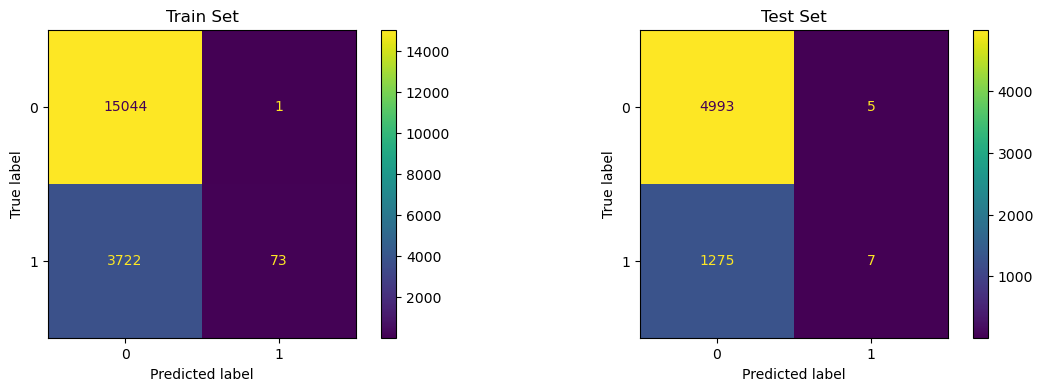

In [407]:
#Limit time or not?
#lagged_data = lagged_data[lagged_data['minutes_lag_avg4'] > 60]

RAND_STATE = 42 # for reproducible shuffling
TT_RATIO = 0.25 # test/train

# X,y
y = lagged_data['return']
X = lagged_data.drop(['return'], axis=1)
#X = X.drop(column_importance_zero, axis=1)

# test-train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

from sklearn.ensemble import RandomForestClassifier

#Original rfc
rfc_ops = {"max_depth":6, #Controls depth for all trees
          'max_features': 'sqrt',
          'min_samples_leaf': 1,
          'min_samples_split': 4,
          "n_estimators":200, #number of trees
          "bootstrap":True, #You can disable this if you don't like
          "oob_score":True, #Out of bag score. Use records that weren't already used. Linked to bootstrap
          "random_state":RAND_STATE}

#rfc based on gridsearch
#rfc_ops = {'bootstrap': True,
 #'max_depth': 10,
 #'max_features': 'sqrt',
 #'max_samples': 0.5,
 #'min_samples_leaf': 1,
 #'min_samples_split': 2,
 #'n_estimators': 100,
  #"random_state":RAND_STATE}

clf = RandomForestClassifier(**rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
print("Decision Tree with Max Depth 6")
performance_log_data = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_train_pred),
                                         precision_score(y_train, y_train_pred, pos_label=1),
                                         recall_score(y_train, y_train_pred, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred),
                                        precision_score(y_test, y_test_pred, pos_label=1),
                                        recall_score(y_test, y_test_pred, pos_label=1)]})

display(performance_log_data)

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(clf,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(clf,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

#Cross Validation
from sklearn.model_selection import cross_val_score
folds=3
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=folds)
print("cv scores over {:d} iterations: \n".format(folds))
cross_val_scores


## Random forest model using  downsampling with RandomUnerSampler

In [379]:
def down_samp_rand(X, y, ratio=1):
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=RAND_STATE)
        X_rus, y_rus = rus.fit_resample(X, y)
        return X_rus, y_rus

RAND_STATE = 42 # for reproducible shuffling
TT_RATIO = 0.25 # test/train

# X,y
y = lagged_data['return']
X = lagged_data.drop(['return'], axis=1)
#X = X.drop(column_importance_zero, axis=1)

# test-train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

X_train_down, y_train_down = down_samp_rand(X_train,y_train)
# check that we have downsampled
y_train_down.value_counts()

0    3206
1    3206
Name: return, dtype: int64

RandomForestClassifier(max_depth=10, max_features='sqrt', max_samples=0.5,
                       random_state=42)

Decision Tree with Max Depth 6


,Error_metric,Train,Test
0,Accuracy,0.866344,0.623090
1,Precision,0.856233,0.338764
2,Recall,0.880536,0.640979


cv scores over 3 iterations: 



array([0.63844715, 0.64950866, 0.63313056])

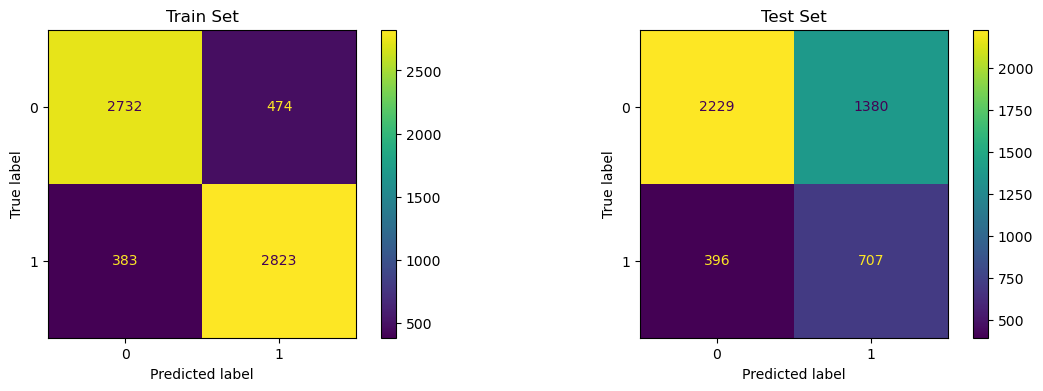

In [381]:
from sklearn.ensemble import RandomForestClassifier

#Original
#rfc_ops_down = {"max_depth":6, #Controls depth for all trees
           #'max_features': 'sqrt',
           #'min_samples_leaf': 1,
           #'min_samples_split': 4,
           #"n_estimators":200, #number of trees
           #"bootstrap":True, #You can disable this if you don't like
           #"oob_score":True, #Out of bag score. Use records that weren't already used. Linked to bootstrap
           #"random_state":RAND_STATE}

#Best from grid Search
rfc_ops_down = {'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
  "random_state":RAND_STATE}

clf_down = RandomForestClassifier(**rfc_ops_down)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf_down.fit(X_train_down, y_train_down)

y_train_pred_down = clf_down.predict(X_train_down)
y_test_pred_down = clf_down.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
print("Decision Tree with Max Depth 6")
performance_log_data_down = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train_down, y_train_pred_down),
                                         precision_score(y_train_down, y_train_pred_down, pos_label=1),
                                         recall_score(y_train_down, y_train_pred_down, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred_down),
                                        precision_score(y_test, y_test_pred_down, pos_label=1),
                                        recall_score(y_test, y_test_pred_down, pos_label=1)]})

display(performance_log_data_down)

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(clf_down,X_train_down,y_train_down,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(clf_down,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

#Cross Validation
from sklearn.model_selection import cross_val_score
folds=3
cross_val_scores_down = cross_val_score(clf_down, X_train_down, y_train_down, cv=folds)
print("cv scores over {:d} iterations: \n".format(folds))
cross_val_scores_down

## Random forest model using SMOTE upsampling

1    10927
0    10927
Name: return, dtype: int64

RandomForestClassifier(max_depth=10, max_features='sqrt', max_samples=0.5,
                       random_state=42)

Random Forest with Up Sampling


,Error_metric,Train,Test
0,Accuracy,0.892468,0.758701
1,Precision,0.982450,0.447205
2,Recall,0.799213,0.130553


cv scores over 3 iterations: 



array([0.55950583, 0.91461908, 0.90293795])

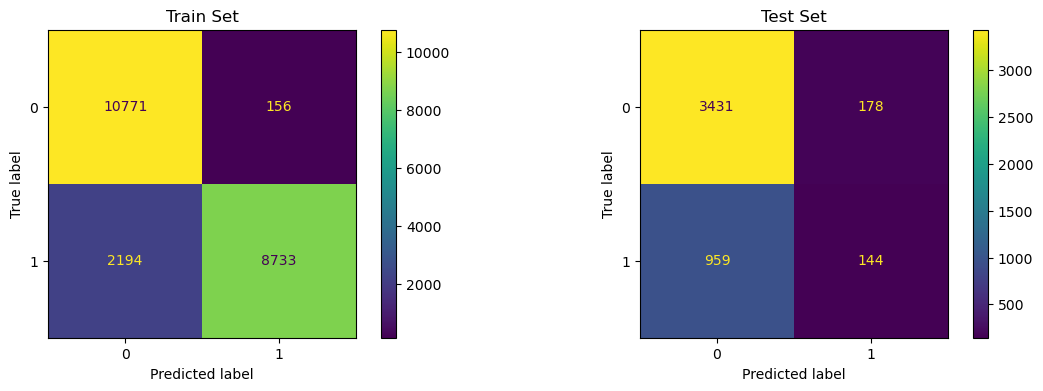

In [382]:
# X,y
y = lagged_data['return']
X = lagged_data.drop(['return'], axis=1)
#X_reduced = X.drop(column_importance_zero, axis=1)

# test-train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

from imblearn.over_sampling import SMOTE
smote = SMOTE()
#fit training data with upsampling
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train_smote.value_counts()

#fit new model with new upsampled data
#original params
#rfc_ops_smote = {"max_depth":6, #Controls depth for all trees
           #'max_features': 'sqrt',
           #'min_samples_leaf': 1,
           #'min_samples_split': 4,
           #"n_estimators":200, #number of trees
           #"bootstrap":True, #You can disable this if you don't like
           #"oob_score":True, #Out of bag score. Use records that weren't already used. Linked to bootstrap
           #"random_state":2}

#Best from grid Search
rfc_ops_smote = {'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
  "random_state":RAND_STATE}

clf_smote = RandomForestClassifier(**rfc_ops_smote)
clf_smote.fit(X_train_smote, y_train_smote)

#Run predictive results for train and test
y_train_pred_smote = clf_smote.predict(X_train_smote)
y_test_pred_smote = clf_smote.predict(X_test)

#Print results
print("Random Forest with Up Sampling")
performance_log_data_smote = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train_smote, y_train_pred_smote),
                                         precision_score(y_train_smote, y_train_pred_smote, pos_label=1),
                                         recall_score(y_train_smote, y_train_pred_smote, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred_smote),
                                        precision_score(y_test, y_test_pred_smote, pos_label=1),
                                        recall_score(y_test, y_test_pred_smote, pos_label=1)]})

display(performance_log_data_smote)

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(clf_smote,X_train_smote,y_train_smote,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(clf_smote,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

#Cross Validation
from sklearn.model_selection import cross_val_score
folds=3
cross_val_scores_smote = cross_val_score(clf_smote, X_train_smote, y_train_smote, cv=folds)
print("cv scores over {:d} iterations: \n".format(folds))
cross_val_scores_smote


# Number of classifiers
I will now see if the model is better at predicting with 4 classifier categories.
The answer is no.
With 4 catergories using this code: #lagged_data['return'] = lagged_data['total_points'].apply(lambda x: '0' if x <= 2 else '1' if x <= 5 else '2' if x <= 8 else '3'), it basically identified everything at 0.

# GridSearch

In [349]:
#GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf' : [1, 2, 3, 4],
    'max_features': ['sqrt'],
    'max_samples' : ['None', 0.5],
    'max_depth':[3,4,5,6,7,10],
    'bootstrap':[True,False]
    }
clf = RandomForestClassifier(random_state=RAND_STATE)

grid_search = GridSearchCV(clf, param_grid, cv=5, return_train_score=True,n_jobs=-1)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_ #To check the best set of parameters returned
best_params

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 4, 5, 6, 7, 10],
                         'max_features': ['sqrt'], 'max_samples': ['None', 0.5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [50, 100, 200, 300]},
             return_train_score=True)

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

# Feature Importance

In [383]:
#Feature importance
feature_names = X_train.columns
df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False).head(10)
column_importance_zero = df[df['score_feature_importance'] < 0.005]['columns_name'].tolist()
column_importance_zero


,columns_name,score_feature_importance
16,oppn_team_proj_score,0.028880
15,p_team_proj_score,0.026455
19,opp_adv_spi,0.026004
6,transfers_in,0.025635
14,oppn_spi,0.022397
5,selected,0.018064
13,p_team_spi,0.014605
10,prob_tie,0.014586
1,position_id,0.014467
30,xP-4,0.013653


['was_home',
 'season_id_x',
 'total_points-2',
 'total_points-3',
 'bonus-1',
 'bonus-2',
 'bonus-3',
 'bonus-4',
 'bonus_lag_avg2',
 'bonus_lag_avg3',
 'bonus_lag_avg4',
 'minutes-1',
 'minutes-2',
 'minutes-3',
 'minutes-4',
 'minutes_lag_avg2',
 'goals-1',
 'goals-2',
 'goals-3',
 'goals-4',
 'goals_lag_avg2',
 'goals_lag_avg3',
 'goals_lag_avg4',
 'shots-1',
 'shots-2',
 'shots-3',
 'shots-4',
 'shots_lag_avg2',
 'shots_lag_avg3',
 'shots_lag_avg4',
 'xG-1',
 'xG-2',
 'xG-3',
 'xA-1',
 'xA-2',
 'xA-4',
 'xA_lag_avg2',
 'assists-1',
 'assists-2',
 'assists-3',
 'assists-4',
 'assists_lag_avg2',
 'assists_lag_avg3',
 'assists_lag_avg4',
 'key_passes-1',
 'key_passes-2',
 'key_passes-3',
 'key_passes-4',
 'key_passes_lag_avg2',
 'key_passes_lag_avg3',
 'key_passes_lag_avg4',
 'npg-1',
 'npg-2',
 'npg-3',
 'npg-4',
 'npg_lag_avg2',
 'npg_lag_avg3',
 'npg_lag_avg4',
 'yellow_cards-1',
 'yellow_cards-2',
 'yellow_cards-3',
 'yellow_cards-4',
 'yellow_cards_lag_avg2',
 'yellow_cards_lag_

In [ ]:
#Can see that position id is an important factor of whether someone will return or not. 

# Random Forest with feature importance (no scaling)


RandomForestClassifier(max_depth=10, max_features='sqrt', max_samples=0.5,
                       random_state=42)

Decision Tree with Max Depth 6


,Error_metric,Train,Test
0,Accuracy,0.807189,0.771222
1,Precision,0.995876,0.704918
2,Recall,0.150655,0.038985


cv scores over 3 iterations: 



array([0.77520696, 0.77648058, 0.77520696])

,columns_name,score_feature_importance
14,oppn_team_proj_score,0.034325
13,p_team_proj_score,0.031189
17,opp_adv_spi,0.028771
3,selected,0.028431
4,transfers_in,0.025975
12,oppn_spi,0.022330
1,position_id,0.018565
8,prob_tie,0.017976
29,xP_lag_avg4,0.017403
23,xP-1,0.016839


[]

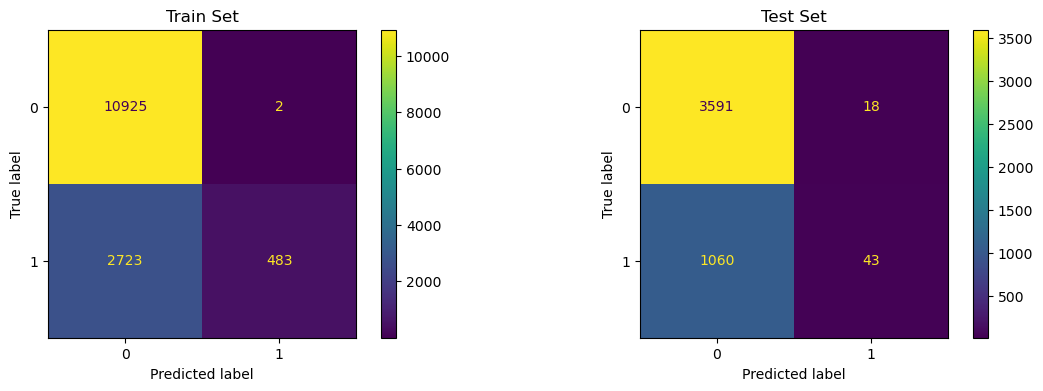

In [386]:
#Reduce features
lagged_data_fi = lagged_data.drop(column_importance_zero, axis=1)

#Limit time or not?
lagged_data_fi = lagged_data_fi[lagged_data_fi['minutes_lag_avg4'] > 60]

RAND_STATE = 42 # for reproducible shuffling
TT_RATIO = 0.25 # test/train

# X,y
y = lagged_data_fi['return']
X = lagged_data_fi.drop(['return'], axis=1)
#X = X.drop(column_importance_zero, axis=1)

# test-train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)

from sklearn.ensemble import RandomForestClassifier

#Original rfc
#rfc_ops = {"max_depth":6, #Controls depth for all trees
          #'max_features': 'sqrt',
          #'min_samples_leaf': 1,
          #'min_samples_split': 4,
          #"n_estimators":200, #number of trees
          #"bootstrap":True, #You can disable this if you don't like
          #"oob_score":True, #Out of bag score. Use records that weren't already used. Linked to bootstrap
          #"random_state":RAND_STATE}

#rfc based on gridsearch
rfc_ops = {'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
  "random_state":RAND_STATE}

clf = RandomForestClassifier(**rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
print("Decision Tree with Max Depth 6")
performance_log_data = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_train_pred),
                                         precision_score(y_train, y_train_pred, pos_label=1),
                                         recall_score(y_train, y_train_pred, pos_label=1)],
                               'Test': [accuracy_score(y_test, y_test_pred),
                                        precision_score(y_test, y_test_pred, pos_label=1),
                                        recall_score(y_test, y_test_pred, pos_label=1)]})

display(performance_log_data)

from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_confusion_matrix(clf,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(clf,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

#Cross Validation
from sklearn.model_selection import cross_val_score
folds=3
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=folds)
print("cv scores over {:d} iterations: \n".format(folds))
cross_val_scores

#Feature importance
feature_names = X_train.columns
df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False).head(10)
column_importance_zero_2 = df[df['score_feature_importance'] < 0.005]['columns_name'].tolist()
column_importance_zero_2


In [394]:
'''
code to return TPs
# convert y_test_pred to a pandas series
y_test_pred = pd.Series(y_test_pred)

# concatenate y_test, y_test_pred, and X_test along the columns axis
data = pd.concat([y_test.reset_index(drop=True), y_test_pred.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

# select the subset of data where y_test and y_test_pred match (true positives)
true_positives = data[(data.iloc[:, 0] == 1) & (data.iloc[:, 1] == 1)]

true_positives
'''

,return,0,player_id,position_id,player_team_id,selected,transfers_in,transfers_out,h_team_id,a_team_id,prob_tie,h_nsxg,a_nsxg,p_team_spi,oppn_spi,p_team_proj_score,oppn_team_proj_score,importance_p_team,importance_oppn_team,opp_adv_spi,total_points-1,total_points-4,total_points_lag_avg2,total_points_lag_avg3,total_points_lag_avg4,xP-1,xP-2,xP-3,xP-4,xP_lag_avg2,xP_lag_avg3,xP_lag_avg4,bps-1,bps-2,bps-3,bps-4,bps_lag_avg2,bps_lag_avg3,bps_lag_avg4,minutes_lag_avg3,minutes_lag_avg4,xG-4,xG_lag_avg2,xG_lag_avg3,xG_lag_avg4,xA-3,xA_lag_avg3,xA_lag_avg4,xGChain-1,xGChain-2,xGChain-3,xGChain-4,xGChain_lag_avg2,xGChain_lag_avg3,xGChain_lag_avg4,xGBuildup-1,xGBuildup-2,xGBuildup-3,xGBuildup-4,xGBuildup_lag_avg2,xGBuildup_lag_avg3,xGBuildup_lag_avg4,influence-1,influence-2,influence-3,influence-4,influence_lag_avg2,influence_lag_avg3,influence_lag_avg4,creativity-1,creativity-2,creativity-3,creativity-4,creativity_lag_avg2,creativity_lag_avg3,creativity_lag_avg4,threat-4,threat_lag_avg2,threat_lag_avg3,threat_lag_avg4,ict_index-1,ict_index-2,ict_index-3,ict_index-4,ict_index_lag_avg2,ict_index_lag_avg3,ict_index_lag_avg4
254,1,1,855,2,16,1282510.0,42094,133901,16,2,0.1231,2.85,0.61,88.83,57.47,2.59,0.47,59.7,40.8,-31.36,1.0,6.0,1.5,1.333333,2.50,1.8,2.5,4.8,12.3,2.15,3.033333,5.350,14.0,16.0,12.0,27.0,15.0,14.000000,17.25,90.000000,90.00,0.097960,0.004920,0.003280,0.026950,0.000000,0.000000,0.006556,0.734981,0.378304,0.590313,0.026224,0.556642,0.567866,0.432455,0.734981,0.368463,0.590313,0.000000,0.551722,0.564586,0.423439,18.6,10.2,16.4,23.0,14.4,15.066667,17.05,1.2,1.5,0.8,10.6,1.35,1.166667,3.525,33.0,2.0,2.000000,9.75,2.2,1.4,1.9,6.7,1.80,1.833333,3.050
354,1,1,855,2,16,1784810.0,18112,38173,16,10,0.1570,2.20,0.52,93.07,77.19,2.53,0.78,100.0,30.9,-15.88,0.0,6.0,3.0,4.666667,5.00,4.7,8.2,15.1,15.1,6.45,9.333333,10.775,9.0,22.0,28.0,22.0,15.5,19.666667,20.25,90.000000,90.00,0.000000,0.015814,0.019267,0.014450,0.000000,0.000000,0.000000,0.431748,0.190091,0.046713,0.438382,0.310920,0.222851,0.276733,0.431748,0.190091,0.046713,0.438382,0.310920,0.222851,0.276733,22.6,10.6,24.2,10.6,16.6,19.133333,17.00,0.6,2.6,1.1,0.6,1.60,1.433333,1.225,2.0,2.0,7.666667,6.25,2.3,1.7,4.4,1.3,2.00,2.800000,2.425
460,1,1,619,1,16,4316520.0,335798,209285,9,16,0.2065,1.39,2.79,89.26,70.79,2.14,1.07,44.6,16.9,-18.47,10.0,6.0,6.5,10.000000,9.00,10.0,11.0,5.0,6.5,10.50,8.666667,8.125,27.0,5.0,49.0,7.0,16.0,27.000000,22.00,90.000000,90.00,0.715508,0.637329,0.504598,0.557325,0.868721,0.364311,0.301144,0.572821,0.909757,1.069630,0.981341,0.741289,0.850736,0.883387,0.297296,0.496967,0.100011,0.235832,0.397131,0.298091,0.282526,46.8,6.4,70.6,22.6,26.6,41.266667,36.60,45.1,26.1,36.4,27.4,35.60,35.866667,33.750,112.0,63.0,65.333333,77.00,14.0,11.1,17.7,16.2,12.55,14.266667,14.750
590,1,1,424,2,16,958469.0,144040,13298,16,18,0.1278,3.65,0.53,93.30,69.61,2.51,0.40,84.4,0.0,-23.69,11.0,8.0,11.0,9.333333,9.00,8.2,13.9,6.2,7.0,11.05,9.433333,8.825,31.0,32.0,25.0,28.0,31.5,29.333333,29.00,90.000000,90.00,0.141084,0.414141,0.276094,0.242342,0.000000,0.027370,0.020528,0.425543,0.098119,0.294139,0.599268,0.261831,0.272600,0.354267,0.425543,0.098119,0.294139,0.599268,0.261831,0.272600,0.354267,49.8,55.6,12.2,33.2,52.7,39.200000,37.70,3.1,10.8,0.7,6.0,6.95,4.866667,5.150,44.0,34.5,23.000000,28.25,7.0,11.8,1.3,8.3,9.40,6.700000,7.100
820,1,1,743,2,11,1844030.0,64929,110492,11,23,0.1263,2.12,0.08,91.64,60.67,2.59,0.46,60.0,38.0,-30.97,2.0,1.0,3.5,2.666667,2.25,3.4,6.0,1.8,0.0,4.70,3.733333,2.800,14.0,20.0,13.0,13.0,17.0,15.666667,15.00,90.000000,90.00,0.000000,0.019999,0.024879,0.018659,0.000000,0.000000,0.016366,0.244392,0.433555,0.550602,0.561154,0.338974,0.409516,0.447426,0.244392,0.433555,0.550602,0.495690,0.338974,0.409516,0.431060,19.8,21.4,24.8,17.6,20.6,22.000000,20.90,1.0,0.7,0.3,10.8,0.85,0.666667,3.200,0.0,10.5,9.000000,6.75,2.3,4.1,3.1,2.8,3.20,3.166667,3.075
832,1,1,234,4,11,933488.0,57817,12510,4,11,0.1194,0.73,2.11,94.14,59.31,2.90,0.68,80.1,45.7,-34.83,7.0,2.0,6.5

# Saving to pickle

In [373]:
#save model with pickle
import pickle
filename = 'clf_feature_i.pkl'
with open(filename, 'wb') as file:
     pickle.dump(clf, file)
     file.close()

#open model with pickle to run predictive tests
with open('clf_feature_i.pkl', 'rb') as file:
    clf_feature_i = pickle.load(file)
    file.close()